# Wrangling with Spark Functions

Real data is rarely clean and ready for analysis. In this chapter learn to remove unneeded information, handle missing values and add additional data to your analysis.

## Preparing the environment

### Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt

from environment import histogram_boxplot
from typing import List

from pyspark.sql.types import (_parse_datatype_string, StructType, StructField,
                               DoubleType, IntegerType, StringType)
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

### Connect to Spark

In [2]:
spark = SparkSession.builder.getOrCreate()

# eval DataFrame in notebooks
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [3]:
sc = spark.sparkContext

### Checking the version of PySpark and Python

In [4]:
print('Spark  version:', spark.version)
print('Python version:', sys.version_info)

Spark  version: 3.5.1
Python version: sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)


### Loading data

In [5]:
# read file
real_state = spark.read.csv('data-sources/2017_StPaul_MN_Real_Estate.csv', header=True, inferSchema=True)

# cast columns
for col_name in ['SQFTBELOWGROUND', 'AssociationFee']:
    real_state = real_state.withColumn(col_name, real_state[col_name].cast('bigint'))
real_state = real_state.withColumn('backonmarketdate', real_state['backonmarketdate'].cast('double'))
real_state = real_state.withColumn("offmarketdate", 
                                       F.to_timestamp(real_state["offmarketdate"], "M/d/yyyy H:m"))

# save to parquet format
file_path = 'spark-warehouse/real_state.parquet'
real_state.write.parquet(file_path, mode="overwrite")
real_state = spark.read.parquet(file_path)
real_state.createOrReplaceTempView("real_state")
real_state.printSchema()
real_state.limit(2)

root
 |-- No.: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: integer (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SalesClosePrice: integer (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: integer (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: integer (nullable = true)
 |-- PricePerTSFT: double (nullable = true)
 |-- FOUNDATIONSIZE: integer (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: integer (nullable = true)
 |-- offmarketdate: timestamp (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- RoomArea4: string (nullabl

No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


### Tables catalogue

In [6]:
spark.catalog.listTables()

[Table(name='real_state', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

## Dropping data

### Dropping Columns

In [7]:
# Preparing the data
df = real_state.select('*')
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [8]:
# Multiple fields are not needed for our analysis
# Noted that only for select need to add '`' since the col name include '.'
df.select('`No.`', 'UNITNUMBER', 'CLASS').show(2)

# List of columns to drop
cols_to_drop = ['No.', 'UNITNUMBER', 'CLASS']  

# Drop the columns
df = df.drop(*cols_to_drop)
print('Dataframe shape after dropping columns:', (df.count(), len(df.columns)))

+---+----------+-----+
|No.|UNITNUMBER|CLASS|
+---+----------+-----+
|  1|      NULL|   SF|
|  2|      NULL|   SF|
+---+----------+-----+
only showing top 2 rows

Dataframe shape after dropping columns: (5000, 71)


### Text Filtering

- `where(condition)`
    - condition – a Column of types.BooleanType or a string of SQL expression.
    - Filters dataframe where the condition is true
- `like(other)`
    - other – a SQL LIKE pattern
    - return a boolean column
- `~`
    - The NOT condition

In [9]:
# Filter data
df = df.where(~df['POTENTIALSHORTSALE'].like('Not Disclosed'))
print('Dataframe shape after text filtering:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape after text filtering: (4989, 71)


MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


### Outlier Filtering

In [10]:
# Calculate values used for filtering
std_val = df.agg({'SALESCLOSEPRICE': 'stddev'}).collect()[0][0]
mean_val = df.agg({'SALESCLOSEPRICE': 'mean'}).collect()[0][0]

print(f'''
    Std: {std_val}
    MEan: {mean_val}
''')


    Std: 140647.09363099682
    MEan: 262861.0811785929



In [11]:
# Create three standard deviation (? ± 3?) upper and lower bounds for data
hi_bound = mean_val + (3 * std_val)
low_bound = mean_val - (3 * std_val)

# Use where() to filter the DataFrame between values
df = df.where((df['LISTPRICE'] < hi_bound) & (df['LISTPRICE'] > low_bound))
print('Dataframe shape after dropping outliers:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape after dropping outliers: (4905, 71)


MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


### Counting nulls in data

In [12]:
# How many null there are
Dict_Null = {col: df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'MLSID': 0,
 'StreetNumberNumeric': 0,
 'streetaddress': 0,
 'STREETNAME': 0,
 'PostalCode': 0,
 'StateOrProvince': 0,
 'City': 0,
 'SalesClosePrice': 0,
 'LISTDATE': 0,
 'LISTPRICE': 0,
 'LISTTYPE': 0,
 'OriginalListPrice': 0,
 'PricePerTSFT': 0,
 'FOUNDATIONSIZE': 0,
 'FENCE': 1978,
 'MapLetter': 0,
 'LotSizeDimensions': 0,
 'SchoolDistrictNumber': 0,
 'DAYSONMARKET': 0,
 'offmarketdate': 0,
 'Fireplaces': 0,
 'RoomArea4': 299,
 'roomtype': 0,
 'ROOF': 754,
 'RoomFloor4': 151,
 'PotentialShortSale': 0,
 'PoolDescription': 3234,
 'PDOM': 0,
 'GarageDescription': 0,
 'SQFTABOVEGROUND': 0,
 'Taxes': 0,
 'RoomFloor1': 334,
 'RoomArea1': 440,
 'TAXWITHASSESSMENTS': 0,
 'TAXYEAR': 0,
 'LivingArea': 0,
 'YEARBUILT': 0,
 'ZONING': 0,
 'STYLE': 0,
 'ACRES': 0,
 'CoolingDescription': 0,
 'APPLIANCES': 322,
 'backonmarketdate': 4905,
 'ROOMFAMILYCHAR': 1940,
 'RoomArea3': 2292,
 'EXTERIOR': 0,
 'RoomFloor3': 2184,
 'RoomFloor2': 976,
 'RoomArea2': 1115,
 'DiningRoomDescription': 636,
 'BASEMEN

### Dropping NA's or NULLs

In [13]:
# drop records if both LISTPRICE and SALESCLOSEPRICE are NULL
df = df.dropna(how='all', subset=['LISTPRICE', 'SALESCLOSEPRICE'])

# Drop records where at least two columns have NULL values
df = df.dropna(thresh=2)

# # Drop any records with NULL values
# df = df.dropna()

# Review the data
print('Dataframe shape after dropping nulls:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape after dropping nulls: (4905, 71)


MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


### Dropping Duplicates

In [14]:
# Entire DataFrame
df.dropDuplicates().count()

4905

In [15]:
# Check only a column list
df.dropDuplicates(['streetaddress']).count()

4890

## Ex. 1 - Dropping a list of columns

Our data set is rich with a lot of features, but not all are valuable. We have many that are going to be hard to wrangle into anything useful. For now, let's remove any columns that aren't immediately useful by dropping them.

- 'STREETNUMBERNUMERIC': The postal address number on the home
- 'FIREPLACES': Number of Fireplaces in the home
- 'LOTSIZEDIMENSIONS': Free text describing the lot shape
- 'LISTTYPE': Set list of values of sale type
- 'ACRES': Numeric area of lot size

**Instructions:**

1. Read the list of column descriptions above and explore their top 30 values with `show()`, the dataframe is already filtered to the listed columns as `df`
2. Create a list of two columns to drop based on their lack of relevance to predicting house prices called `cols_to_drop`. Recall that computers only interpret numbers explicitly and don't understand context.
3. Use the `drop()` function to remove the columns in the list `cols_to_drop` from the dataframe `df`.

In [16]:
# Initializing the data
df = real_state.select('STREETNUMBERNUMERIC','FIREPLACES','LOTSIZEDIMENSIONS','LISTTYPE','ACRES')
print('Dataframe shape', (df.count(), len(df.columns)))

# Show top 30 records
df.show(30)

Dataframe shape (5000, 5)
+-------------------+----------+--------------------+---------------+-----+
|STREETNUMBERNUMERIC|FIREPLACES|   LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|
+-------------------+----------+--------------------+---------------+-----+
|              11511|         0|             279X200|Exclusive Right| 1.28|
|              11200|         0|             100x140|Exclusive Right| 0.32|
|               8583|         0|             120x296|Exclusive Right|0.822|
|               9350|         1|             208X208|Exclusive Right| 0.94|
|               2915|         1|             116x200|Exclusive Right|  0.0|
|               3604|         1|              50x150|Exclusive Right|0.172|
|               9957|         0|              common|Exclusive Right| 0.05|
|               9934|         0|              common|Exclusive Right| 0.05|
|               9926|         0|              common|Exclusive Right| 0.05|
|               9928|         0|              common|Exclusive

In [17]:
# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 3)


FIREPLACES,LISTTYPE,ACRES
0,Exclusive Right,1.28
0,Exclusive Right,0.32


## Ex. 2 - Using text filters to remove records

It pays to have to ask your clients lots of questions and take time to understand your variables. You find out that Assumable mortgage is an unusual occurrence in the real estate industry and your client suggests you exclude them. In this exercise we will use `isin()` which is similar to `like()` but allows us to pass a list of values to use as a filter rather than a single one.

**Instructions:**

1. Use `select()` and `show()` to inspect the distinct values in the column `'ASSUMABLEMORTGAGE'` and create the list `yes_values` for all the values containing the string `'Yes'`.
2. Use `~df['ASSUMABLEMORTGAGE']`, `isin()`, and `.isNull()` to create a NOT filter to remove records containing corresponding values in the list `yes_values` and to keep records with null values. Store this filter in the variable `text_filter`.
3. Use `where()` to apply the `text_filter` to `df`.
4. Print out the number of records remaining in `df`.

In [18]:
# Initializing the data
df = real_state.select('*')

print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [19]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|Yes w/No Qualifying|
|      Not Assumable|
|               NULL|
+-------------------+



In [20]:
# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.filter(text_filter)

# Print count of remaining records
print('Dataframe shape:', (df.count(), len(df.columns)))

Dataframe shape: (4976, 74)


## Ex. 3 - Filtering numeric fields conditionally

Again, understanding the context of your data is extremely important. We want to understand what a normal range of houses sell for. Let's make sure we exclude any outlier homes that have sold for significantly more or less than the average. Here we will calculate the mean and standard deviation and use them to filer the near normal field `log_SalesClosePrice`.

**Instructions:**

1. Import `mean()` and `stddev()` from `pyspark.sql.functions`. (Already done)
2. Use `agg()` to calculate the mean and standard deviation for `'log_SalesClosePrice'` with the imported functions.
3. Create the upper and lower bounds by taking `mean_val` +/- 3 times `stddev_val`.
4. Create a `where()` filter for `'log_SalesClosePrice'` using both `low_bound` and `hi_bound`.

In [21]:
# Initializing the data
df = real_state.select('*')
df = df.withColumn('log_SalesClosePrice', F.log('SalesClosePrice'))
    
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 75)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation,log_SalesClosePrice
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0,11.870599909242044
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0,12.154779351142624


In [22]:
df.select('SalesClosePrice', 'log_SalesClosePrice').show(5)

+---------------+-------------------+
|SalesClosePrice|log_SalesClosePrice|
+---------------+-------------------+
|         143000| 11.870599909242044|
|         190000| 12.154779351142624|
|         225000| 12.323855681186558|
|         265000| 12.487485104968359|
|         249900| 12.428816116823043|
+---------------+-------------------+
only showing top 5 rows



In [23]:
# Calculate values used for outlier filtering
mean_val = df.agg(F.mean('log_SalesClosePrice')).collect()[0][0]
stddev_val = df.agg(F.stddev('log_SalesClosePrice')).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))

print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (4968, 75)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation,log_SalesClosePrice
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0,11.870599909242044
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0,12.154779351142624


## Adjusting Data

### Minmax Scaling

In [24]:
# Initializing the data
df = real_state.select('*')    
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [25]:
# define min and max values and collect them
max_days = df.agg(F.max('DAYSONMARKET')).collect()[0][0]
min_days = df.agg(F.min('DAYSONMARKET')).collect()[0][0]

# create a new column based off the scaled data
df = df.withColumn("scaled_days", (df['DAYSONMARKET'] - min_days) / (max_days - min_days))
df[['DAYSONMARKET', 'scaled_days']].show(5)

+------------+--------------------+
|DAYSONMARKET|         scaled_days|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
+------------+--------------------+
only showing top 5 rows



### Standardization

In [26]:
mean_days = df.agg(F.mean('DAYSONMARKET')).collect()[0][0]
stddev_days = df.agg(F.stddev('DAYSONMARKET')).collect()[0][0]

# Create a new column with the scaled data
df = df.withColumn("ztrans_days", (df['DAYSONMARKET'] - mean_days) / stddev_days)
df[['DAYSONMARKET', 'ztrans_days']].show(5)

+------------+--------------------+
|DAYSONMARKET|         ztrans_days|
+------------+--------------------+
|          10| -0.6394716073380993|
|           4| -0.8484674699420623|
|          28|-0.01248401952621...|
|          19|-0.32597781343215465|
|          21| -0.2563125258975003|
+------------+--------------------+
only showing top 5 rows



In [27]:
print(f'''
Mean before transformation: {mean_days:0.4f}
Mean after transformation : {df.agg(F.mean('ztrans_days')).collect()[0][0]:0.4f}

Std. before transformation: {stddev_days:0.4f}
Std. after transformation : {df.agg(F.stddev('ztrans_days')).collect()[0][0]:0.4f}
''')


Mean before transformation: 28.3584
Mean after transformation : -0.0000

Std. before transformation: 28.7087
Std. after transformation : 1.0000



### Log Scaling

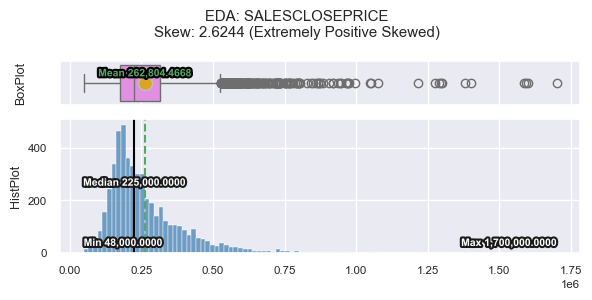

In [28]:
# Using our library
column_name = 'SalesClosePrice'
histogram_boxplot(df.select(column_name).toPandas()[column_name])

In [29]:
# Recalculate log of SALESCLOSEPRICE
df = df.withColumn('log_SalesClosePrice', F.log('SalesClosePrice'))
df[['SalesClosePrice', 'log_SalesClosePrice']].show(5)

+---------------+-------------------+
|SalesClosePrice|log_SalesClosePrice|
+---------------+-------------------+
|         143000| 11.870599909242044|
|         190000| 12.154779351142624|
|         225000| 12.323855681186558|
|         265000| 12.487485104968359|
|         249900| 12.428816116823043|
+---------------+-------------------+
only showing top 5 rows



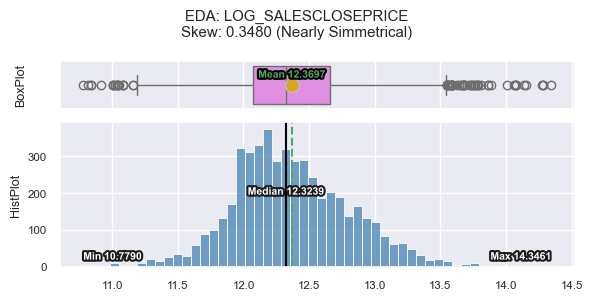

In [30]:
# Using our library
column_name = 'log_SalesClosePrice'
histogram_boxplot(df.select(column_name).toPandas()[column_name])

## Ex. 4 - Custom Percentage Scaling

**Instructions:**

1. Calculate the `max` and `min` of `DAYSONMARKET` and put them into variables `max_days` and `min_days`, don't forget to use `collect()` on `agg()`.
2. Using `withColumn()` create a new column called `'percentagescaleddays'` based on `DAYSONMARKET`.
3. `percentage_scaled_days` should be a column of integers ranging from `0` to `100`, use `round()` to get integers.
4. Print the `max()` and `min()` for the new column `percentage_scaled_days`.

In [31]:
# Initializing the data
df = real_state.select('*')    
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [32]:
# Define max and min values and collect them
max_days = df.agg(F.max('DAYSONMARKET')).collect()[0][0]
min_days = df.agg(F.min('DAYSONMARKET')).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentage_scaled_days', 
                   F.round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)

# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


## Ex. 5 - Scaling your scalers
In the previous exercise, we minmax scaled a single variable. Suppose you have a LOT of variables to scale, you don't want hundreds of lines to code for each. Let's expand on the previous exercise and make it a function.

**Instructions:**

1. Define a function called `min_max_scaler` that takes parameters `df` a dataframe and `cols_to_scale` the list of columns to scale.
2. Use a `for` loop to iterate through each column in the list and minmax scale them.
3. Return the dataframe `df` with the new columns added.
4. Apply the function `min_max_scaler()` on `df` and the list of columns

In [33]:
# Initializing the data
df = real_state.select('*')    
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [34]:
# Define the function to scale a set of defined columns
def min_max_scaler(df: pd.DataFrame, cols_to_scale: List) -> pd.DataFrame:
    '''Takes a dataframe and list of columns to minmax scale. Returns a dataframe.'''
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_days = df.agg({col: 'max'}).collect()[0][0]
        min_days = df.agg({col: 'min'}).collect()[0][0]
        
        # Create a new column based off the scaled data
        new_column_name = 'scaled_' + col
        df = df.withColumn(new_column_name,
                           (df[col] - min_days) / (max_days - min_days))
    return df

In [35]:
# Scale multiple columns
cols_to_scale = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']
df = min_max_scaler(df, cols_to_scale)

# Show that our data is now between 0 and 1
df[['FOUNDATIONSIZE', 'scaled_FOUNDATIONSIZE', 
    'DAYSONMARKET', 'scaled_DAYSONMARKET',
    'FIREPLACES', 'scaled_FIREPLACES']].show(3)

+--------------+---------------------+------------+--------------------+----------+-----------------+
|FOUNDATIONSIZE|scaled_FOUNDATIONSIZE|DAYSONMARKET| scaled_DAYSONMARKET|FIREPLACES|scaled_FIREPLACES|
+--------------+---------------------+------------+--------------------+----------+-----------------+
|           980|  0.25824320759694014|          10|0.044444444444444446|         0|              0.0|
|          1144|   0.3015035610656819|           4|0.017777777777777778|         0|              0.0|
|          1102|  0.29042469005539434|          28| 0.12444444444444444|         0|              0.0|
+--------------+---------------------+------------+--------------------+----------+-----------------+
only showing top 3 rows



## Ex. 5 - Correcting Right Skew Data

In the slides we showed how you might use **log transforms to fix positively skewed data** (data whose **distribution is mostly to the left**). To correct **negative skew (data mostly to the right)** you need to take an extra step called **"reflecting"** before you can apply the inverse of `log`, written as `(1/log)` to make the data look more like normal a normal distribution. Reflecting data uses the following formula to reflect each value: 

$$ (x_{max} + 1) - x $$

**Instructions:**

1. Use the aggregate function `skewness()` to verify that `'YEARBUILT'` has negative skew.
2. Use the `withColumn()` to create a new column `'Reflect_YearBuilt'` and reflect the values of `'YEARBUILT'`.
3. Using `'Reflect_YearBuilt'` column, create another column `'adj_yearbuilt'` by taking `1/log()` of the values.

In [36]:
# Initializing the data
df = real_state.select('*')    
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


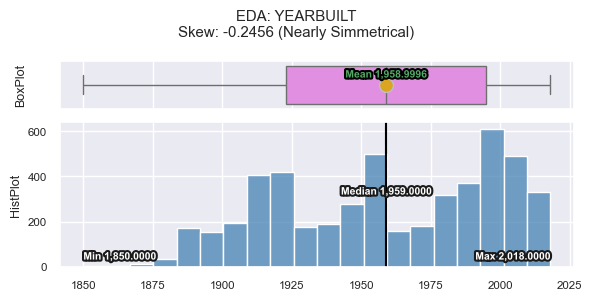

In [37]:
# Using our library
column_name = 'YEARBUILT'
histogram_boxplot(df.select(column_name).toPandas()[column_name])

In [38]:
# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg(F.max('YEARBUILT')).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data (this one is the fix)
df = df.withColumn('adj_yearbuilt', 1 / F.log(df['Reflect_YearBuilt']))
df.select(['YEARBUILT', 'adj_yearbuilt']).show(5)

[Row(skewness(YEARBUILT)=-0.2455425013492729)]
+---------+-------------------+
|YEARBUILT|      adj_yearbuilt|
+---------+-------------------+
|     1950|0.23617733727628992|
|     1971| 0.2583177668073288|
|     1949|0.23537745555238682|
|     1960| 0.2452460618098304|
|     1978|  0.269282508064391|
+---------+-------------------+
only showing top 5 rows



[Row(skewness(adj_yearbuilt)=4.081397653256459)]


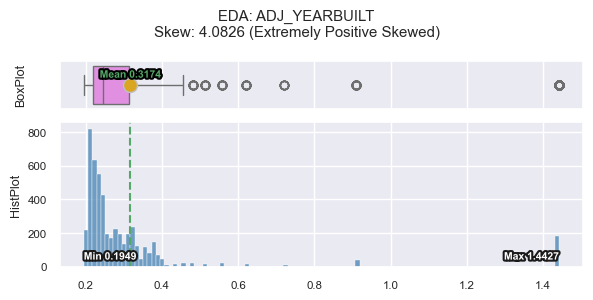

In [39]:
print(df.agg({'adj_yearbuilt': 'skewness'}).collect())

# Using our library
column_name = 'adj_yearbuilt'
histogram_boxplot(df.select(column_name).toPandas()[column_name])

## Working with Missing Data

In [40]:
# Initializing the data
df = real_state.select('*')    
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


### Assessing Missing Values

In [41]:
df.where(df['ROOF'].isNull()).count()

765

In [42]:
df.where(df['ROOMAREA1'].isNull()).count()

457

In [43]:
# How many null there are
Dict_Null = {col: df.filter(df[f"`{col}`"].isNull()).count() for col in df.columns}

# Filtering columns without null values
Dict_Null = {k: v for k, v in Dict_Null.items() if v != 0}
Dict_Null

{'FENCE': 2028,
 'RoomArea4': 303,
 'ROOF': 765,
 'RoomFloor4': 153,
 'PoolDescription': 3293,
 'RoomFloor1': 349,
 'RoomArea1': 457,
 'UNITNUMBER': 4394,
 'APPLIANCES': 331,
 'backonmarketdate': 5000,
 'ROOMFAMILYCHAR': 1960,
 'RoomArea3': 2312,
 'RoomFloor3': 2201,
 'RoomFloor2': 982,
 'RoomArea2': 1125,
 'DiningRoomDescription': 648,
 'BATHSTHREEQUARTER': 1,
 'BATHDESC': 366,
 'RoomArea5': 246,
 'RoomFloor5': 145,
 'RoomArea6': 391,
 'RoomFloor6': 293,
 'RoomArea7': 1527,
 'RoomFloor7': 1441,
 'RoomArea8': 3485,
 'RoomFloor8': 3439,
 'AssumableMortgage': 3104}

### Plotting Missing Values

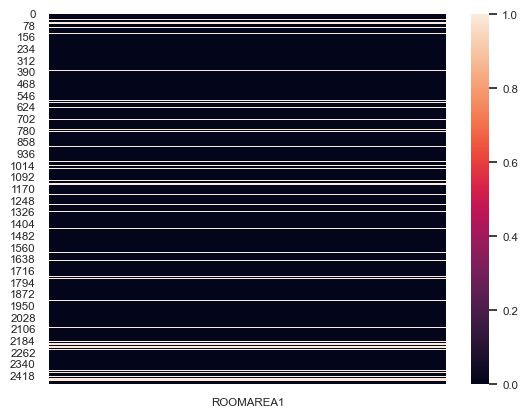

In [44]:
# subset the dataframe
sub_df = df.select(['ROOMAREA1'])

# sample the dataframe
sample_df = sub_df.sample(withReplacement=False, fraction=0.5, seed=4)

# Convert to Pandas DataFrame
pandas_df = sample_df.toPandas()

# Plot it
sns.heatmap(data=pandas_df.isnull())
plt.show()

### Imputation of Missing Values

`fillna(value, subset=None)`

- `value` the value to replace missings with
- `subset` the list of column names to replace missings

In [45]:
# Assesing null values
df.where(df['DAYSONMARKET'].isNull()).count()

0

In [46]:
# Replacing missing values with zero
df.fillna(0, subset=['DAYSONMARKET']).select('DAYSONMARKET').show(2)

+------------+
|DAYSONMARKET|
+------------+
|          10|
|           4|
+------------+
only showing top 2 rows



In [47]:
# Replacing with the mean value for that column
col_mean = df.agg(F.mean('DAYSONMARKET')).collect()[0][0]
df.fillna(col_mean, subset=['DAYSONMARKET']).select('DAYSONMARKET').show(2)

+------------+
|DAYSONMARKET|
+------------+
|          10|
|           4|
+------------+
only showing top 2 rows



## Ex. 6 - Visualizing Missing Data

Being able to plot missing values is a great way to quickly understand how much of your data is missing. It can also help highlight when variables are missing in a pattern something that will need to be handled with care lest your model be biased.

Which variable has the most missing values? 

**Instructions:**

1. Use `select()` to subset the dataframe df with the list of columns columns and Sample with the provided `sample()` function, and assign this dataframe to the variable `sample_df`.
2. Convert the Subset dataframe to a pandas dataframe `pandas_df`, and use pandas `isnull()` to convert it DataFrame into `True/False`. Store this result in `tf_df`.
3. Use seaborn's `heatmap()` to plot `tf_df`.
4. Run Code to view the plot. Then assign the name of the variable with most missing values to answer.

In [48]:
# Initializing the data
df = real_state.select('*')    
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


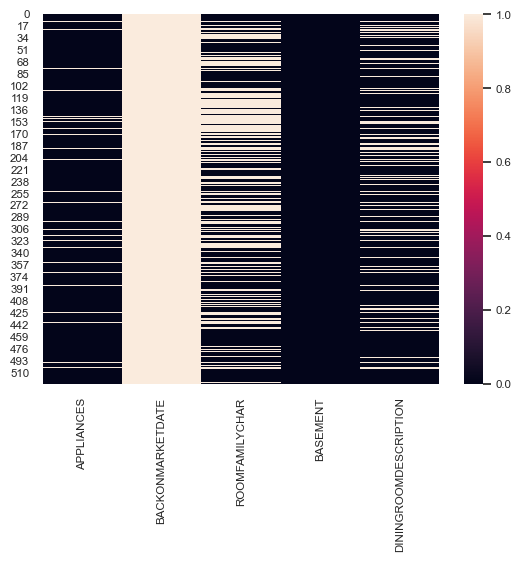

In [49]:
# Sample the dataframe and convert to Pandas
columns = ['APPLIANCES', 'BACKONMARKETDATE', 'ROOMFAMILYCHAR', 'BASEMENT', 'DININGROOMDESCRIPTION']
sample_df = df.select(columns).sample(False, 0.1, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
sns.heatmap(data=tf_df)
plt.show()

In [50]:
# Assesing null values
for col in columns:
    print(f'{col:>21}: {df.where(df[col].isNull()).count():>4} null values')

           APPLIANCES:  331 null values
     BACKONMARKETDATE: 5000 null values
       ROOMFAMILYCHAR: 1960 null values
             BASEMENT:    0 null values
DININGROOMDESCRIPTION:  648 null values


In [51]:
# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

## Ex. 7 - Imputing Missing Data

Missing data happens. If we make the assumption that our data is missing completely at random, we are making the assumption that what data we do have, is a good representation of the population. If we have a few values we could remove them or we could use the mean or median as a replacement. In this exercise, we will look at `'PDOM'`: Days on Market at Current Price.

**Instructions:**

1. Get a count of the missing values in the column `'PDOM'` using `where()`, `isNull()` and `count()`.
2. Calculate the mean value of `'PDOM'` using the aggregate function `mean()`.
3. Use `fillna()` with the value set to the `'PDOM'` mean value and only apply it to the column `'PDOM'` using the subset parameter.

In [52]:
# Initializing the data
df = real_state.select('*')    
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [53]:
# Count missing rows - Ilustrative procedure
missing = df.where(df['PDOM'].isNull()).count()
missing

0

In [54]:
# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df = df.fillna(col_mean, subset=['PDOM'])

## Ex. 8 - Calculate Missing Percents

Automation is the future of data science. Learning to automate some of your data preparation pays dividends. In this exercise, we will automate dropping columns if they are missing data beyond a specific threshold.

**Instructions:**

1. Define a function `column_dropper()` that takes the parameters `df` a dataframe and `threshold` a float between 0 and 1.
2. Calculate the percentage of values that are missing using `where()`, `isNull()` and `count()`
3. Check to see if the percentage of missing is higher than the `threshold`, if so, drop the column using `drop()`
4. Run `column_dropper()` on `df` with the `threshold` set to `.6`

In [55]:
# Initializing the data
df = real_state.select('*')    
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [56]:
# How many null there are
Dict_Null = {col: df.filter(df[f"`{col}`"].isNull()).count() for col in df.columns}
total_rows = df.count()

# Filtering columns without null values
{k: v/total_rows  for k, v in Dict_Null.items() if v != 0}

{'FENCE': 0.4056,
 'RoomArea4': 0.0606,
 'ROOF': 0.153,
 'RoomFloor4': 0.0306,
 'PoolDescription': 0.6586,
 'RoomFloor1': 0.0698,
 'RoomArea1': 0.0914,
 'UNITNUMBER': 0.8788,
 'APPLIANCES': 0.0662,
 'backonmarketdate': 1.0,
 'ROOMFAMILYCHAR': 0.392,
 'RoomArea3': 0.4624,
 'RoomFloor3': 0.4402,
 'RoomFloor2': 0.1964,
 'RoomArea2': 0.225,
 'DiningRoomDescription': 0.1296,
 'BATHSTHREEQUARTER': 0.0002,
 'BATHDESC': 0.0732,
 'RoomArea5': 0.0492,
 'RoomFloor5': 0.029,
 'RoomArea6': 0.0782,
 'RoomFloor6': 0.0586,
 'RoomArea7': 0.3054,
 'RoomFloor7': 0.2882,
 'RoomArea8': 0.697,
 'RoomFloor8': 0.6878,
 'AssumableMortgage': 0.6208}

In [57]:
# Filtering columns with null values proportion greater than 0.6
{k: v/total_rows  for k, v in Dict_Null.items() if v/total_rows > 0.6}

{'PoolDescription': 0.6586,
 'UNITNUMBER': 0.8788,
 'backonmarketdate': 1.0,
 'RoomArea8': 0.697,
 'RoomFloor8': 0.6878,
 'AssumableMortgage': 0.6208}

In [58]:
# Function to automate dropping columns
def column_dropper(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    '''Takes a dataframe and threshold for missing values. Returns a dataframe.'''
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[f'`{col}`'].isNull()).count()
        missing_percent = missing / total_records
        
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

# Drop columns that are more than 60% missing
df = column_dropper(df, 0.6)

print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 68)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,Bedrooms,SQFTBELOWGROUND,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,3,0,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,4,960,0,Unknown,0.0


In [59]:
# How many null there are
Dict_Null = {col: df.filter(df[f"`{col}`"].isNull()).count() for col in df.columns}
total_rows = df.count()

# Filtering columns with null values proportion greater than 0.6
{k: v/total_rows  for k, v in Dict_Null.items() if v/total_rows > 0.6}

{}

## Getting More Data

In [60]:
# Initializing the data
df = real_state.select('*')
df.createOrReplaceTempView("df")
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


### PySpark DataFrame Joins

In [61]:
df.select(F.year('OFFMARKETDATE')).distinct().show()

+-------------------+
|year(OFFMARKETDATE)|
+-------------------+
|               2018|
|               2017|
+-------------------+



In [62]:
# Loading a holiday datasets
holiday = spark.read.csv('data-sources/USHolidayDates2017-2018.csv', header=True, inferSchema=True)

# cast columns
holiday = holiday.withColumn("Date", F.to_date(holiday["Date"], "M/d/yyyy"))
holiday.createOrReplaceTempView("holiday")
holiday.printSchema()
holiday.limit(2)

root
 |-- Date: date (nullable = true)
 |-- Holiday: string (nullable = true)
 |-- WeekDay: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Year: integer (nullable = true)



Date,Holiday,WeekDay,Month,Day,Year
2017-07-04,4th of July,Tuesday,7,4,2017
2018-07-04,4th of July,Wednesday,7,4,2018


In [63]:
holiday.select(F.year('Date')).distinct().show()

+----------+
|year(Date)|
+----------+
|      2018|
|      2017|
+----------+



In [64]:
# Specify join conditon
cond = [df['OFFMARKETDATE'] == holiday['Date']]

# Join two holiday onto df
df_holiday = df.join(holiday, on=cond, how='left')

# How many sales occurred on bank holidays?
print(
    'How many sales occurred on bank holidays?', 
    df_holiday.where(~df_holiday['Holiday'].isNull()).count()
)

How many sales occurred on bank holidays? 94


In [65]:
df_holiday.where(~df_holiday['Holiday'].isNull()).select(['OFFMARKETDATE', 'Date', 'Holiday']).show(94)

+-------------------+----------+--------------------+
|      OFFMARKETDATE|      Date|             Holiday|
+-------------------+----------+--------------------+
|2017-11-11 00:00:00|2017-11-11|        Veterans Day|
|2017-06-19 00:00:00|2017-06-19|          Juneteenth|
|2017-10-09 00:00:00|2017-10-09|        Columbus Day|
|2017-10-09 00:00:00|2017-10-09|        Columbus Day|
|2017-06-19 00:00:00|2017-06-19|          Juneteenth|
|2017-06-19 00:00:00|2017-06-19|          Juneteenth|
|2017-04-16 00:00:00|2017-04-16|      Western Easter|
|2017-04-16 00:00:00|2017-04-16|      Eastern Easter|
|2017-10-09 00:00:00|2017-10-09|        Columbus Day|
|2017-10-09 00:00:00|2017-10-09|        Columbus Day|
|2017-11-22 00:00:00|2017-11-22|    Thanksgiving Eve|
|2017-09-02 00:00:00|2017-09-02|   Labor Day Weekend|
|2017-11-22 00:00:00|2017-11-22|    Thanksgiving Eve|
|2017-09-02 00:00:00|2017-09-02|   Labor Day Weekend|
|2017-09-02 00:00:00|2017-09-02|   Labor Day Weekend|
|2017-09-04 00:00:00|2017-09

### SparkSQL Join

In [66]:
# Tables catalogue
spark.catalog.listTables()

[Table(name='df', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='holiday', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='real_state', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [67]:
# Write a SQL Statement
sql_df = spark.sql("""
    SELECT *
    FROM df
    LEFT JOIN holiday 
        ON df.OFFMARKETDATE = holiday.date
""")
# How many sales occurred on bank holidays?
print(
    'How many sales occurred on bank holidays?', 
    sql_df.where(~df_holiday['Holiday'].isNull()).count()
)

How many sales occurred on bank holidays? 94


In [68]:
sql_df.where(~df_holiday['Holiday'].isNull()).select(['OFFMARKETDATE', 'Date', 'Holiday']).show(5)

+-------------------+----------+------------+
|      OFFMARKETDATE|      Date|     Holiday|
+-------------------+----------+------------+
|2017-11-11 00:00:00|2017-11-11|Veterans Day|
|2017-06-19 00:00:00|2017-06-19|  Juneteenth|
|2017-10-09 00:00:00|2017-10-09|Columbus Day|
|2017-10-09 00:00:00|2017-10-09|Columbus Day|
|2017-06-19 00:00:00|2017-06-19|  Juneteenth|
+-------------------+----------+------------+
only showing top 5 rows



## Ex. 9 - A Dangerous Join

In this exercise, we will be joining on Latitude and Longitude to bring in another dataset that measures how walk-friendly a neighborhood is. We'll need to be careful to make sure our joining columns are the same data type and ensure we are joining on the same precision (number of digits after the decimal) or our join won't work!

Below you will find that df['latitude'] and df['longitude'] are at a higher precision than walk_df['longitude'] and walk_df['latitude'] we'll need to round them to the same precision so the join will work correctly.

**Instructions:**

1. Convert `walk_df['latitude']` and `walk_df['longitude']` to type `double` by using `cast('double')` on the column and replacing the column in place `withColumn()`.
2. Round the columns in place with `withColumn()` and `round('latitude', 5)` and `round('longitude', 5)`.
3. Create the join condition of `walk_df['latitude']` matching `df['latitude']` and `walk_df['longitude']` matching `df['longitude']`.
4. Join `df` and `walk_df` together with `join()`, using the condition above and the `left` join type. Save the joined dataframe as `join_df`.

In [69]:
# load the real-state-coord.csv
path_file = 'data-sources/real-state-coord.csv'
df = spark.read.csv('data-sources/real-state-coord.csv', header=True, inferSchema=True)
for col_name in ['SQFTBELOWGROUND', 'AssociationFee']:
    df = df.withColumn(col_name, df[col_name].cast('bigint'))
df = df.withColumn('backonmarketdate', df['backonmarketdate'].cast('double'))
df = df.withColumn("OFFMKTDATE", F.to_timestamp(df["OFFMKTDATE"], "M/d/yyyy H:m"))
df.createOrReplaceTempView("df")
print('Dataframe shape:', (df.count(), len(df.columns)))
df.printSchema()
df.limit(2)

Dataframe shape: (5000, 54)
root
 |-- NO: integer (nullable = true)
 |-- STREETADDRESS: string (nullable = true)
 |-- POSTALCODE: integer (nullable = true)
 |-- STATEORPROVINCE: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- SALESCLOSEPRICE: integer (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: integer (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- ORIGINALLISTPRICE: integer (nullable = true)
 |-- PRICEPERTSFT: double (nullable = true)
 |-- FOUNDATIONSIZE: integer (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- SCHOOLDISTRICTNUMBER: string (nullable = true)
 |-- DAYSONMARKET: integer (nullable = true)
 |-- OFFMKTDATE: timestamp (nullable = true)
 |-- FIREPLACES: integer (nullable = true)
 |-- ROOMTYPE: string (nullable = true)
 |-- ROOF: string (nullable = true)
 |-- POTENTIALSHORTSALE: string (nullable = true)
 |-- POOLDESCRIPTION: string (nullable = true)
 |-- PDOM: integer (nullable = true)
 |-- GARAGEDESCRIP

NO,STREETADDRESS,POSTALCODE,STATEORPROVINCE,CITY,SALESCLOSEPRICE,LISTDATE,LISTPRICE,LISTTYPE,ORIGINALLISTPRICE,PRICEPERTSFT,FOUNDATIONSIZE,FENCE,SCHOOLDISTRICTNUMBER,DAYSONMARKET,OFFMKTDATE,FIREPLACES,ROOMTYPE,ROOF,POTENTIALSHORTSALE,POOLDESCRIPTION,PDOM,GARAGEDESCRIPTION,SQFTABOVEGROUND,TAXES,TAXWITHASSESSMENTS,TAXYEAR,LIVINGAREA,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,COOLINGDESCRIPTION,APPLIANCES,backonmarketdate,EXTERIOR,DININGROOMDESCRIPTION,BASEMENT,BATHSFULL,BATHSHALF,BATHQUARTER,BATHSTHREEQUARTER,CLASS,BATHSTOTAL,BATHDESC,BEDROOMS,SQFTBELOWGROUND,ASSUMABLEMORTGAGE,AssociationFee,ASSESSMENTPENDING,ASSESSEDVALUATION,latitude,longitude
1,11511 Stillwater ...,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,834 - Stillwater,10,2017-07-30 00:00:00,0,"Living Room,Dinin...",null,No,null,10,Attached Garage,980,1858,1858,2017,980,null,1950,Residential-Single,(SF) One Story,1.28,Central,"Range,Dishwasher,...",NULL,Vinyl,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,3,0,null,0,Unknown,0,45.00585,-92.87286
2,11200 31st St N,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,null,834 - Stillwater,4,2017-10-13 00:00:00,0,"Living Room,Dinin...","Asphalt Shingles,...",No,null,4,"Attached Garage,D...",1268,1640,1640,2017,2228,null,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range,Microwave,E...",NULL,Vinyl,Informal Dining R...,"Full,Partial Fini...",1,0,0,2,SF,3,Main Floor Full B...,4,960,null,0,Unknown,0,44.99488,-92.87927


In [70]:
df.select(['latitude', 'longitude']).show(5)

+--------+---------+
|latitude|longitude|
+--------+---------+
|45.00585|-92.87286|
|44.99488|-92.87927|
|44.99225|-92.93276|
| 44.9948|-92.87797|
|44.99087| -92.9338|
+--------+---------+
only showing top 5 rows



In [71]:
# Loading the walk_df datasets
walk_df = spark.read.csv('data-sources/walk.csv', header=True, inferSchema=True)
walk_df.createOrReplaceTempView("walk_df")
walk_df = walk_df.withColumnRenamed("latitude", "latitude_walk").withColumnRenamed("longitude", "longitude_walk")
print('Dataframe shape:', (walk_df.count(), len(walk_df.columns)))
walk_df.printSchema()
walk_df.limit(2)

Dataframe shape: (4243, 5)
root
 |-- latitude_walk: double (nullable = true)
 |-- longitude_walk: double (nullable = true)
 |-- walkscore: integer (nullable = true)
 |-- bikescore: string (nullable = true)
 |-- transitscore: string (nullable = true)



latitude_walk,longitude_walk,walkscore,bikescore,transitscore
44.92635,-93.18928,61,72,null
44.9581,-93.17982,74,83,null


In [72]:
# How many null there are
Dict_Null = {col: df.filter(df[f"`{col}`"].isNull()).count() for col in df.columns}

# Filtering columns without null values
Dict_Null = {k: v for k, v in Dict_Null.items() if v != 0}
Dict_Null

{'backonmarketdate': 5000,
 'BATHSTHREEQUARTER': 1,
 'latitude': 151,
 'longitude': 151}

In [73]:
# Round precision
df = df.withColumn('longitude', F.round('longitude', 5))
df = df.withColumn('latitude', F.round('latitude', 5))
walk_df = walk_df.withColumn('longitude_walk', F.round('longitude_walk', 5))
walk_df = walk_df.withColumn('latitude_walk', F.round('latitude_walk', 5))

# Create join condition
condition = [walk_df['longitude_walk'] == df['longitude'], walk_df['latitude_walk'] == df['latitude']]

# Join the dataframes together
join_df = df.join(walk_df, on=condition, how='left')

# Count non-null records from new field
print(
    'Count non-null records from new field:',
    join_df.where(~join_df['walkscore'].isNull()).count()
)

Count non-null records from new field: 4849


In [74]:
join_df.where(join_df['walkscore'].isNull()).limit(5)

NO,STREETADDRESS,POSTALCODE,STATEORPROVINCE,CITY,SALESCLOSEPRICE,LISTDATE,LISTPRICE,LISTTYPE,ORIGINALLISTPRICE,PRICEPERTSFT,FOUNDATIONSIZE,FENCE,SCHOOLDISTRICTNUMBER,DAYSONMARKET,OFFMKTDATE,FIREPLACES,ROOMTYPE,ROOF,POTENTIALSHORTSALE,POOLDESCRIPTION,PDOM,GARAGEDESCRIPTION,SQFTABOVEGROUND,TAXES,TAXWITHASSESSMENTS,TAXYEAR,LIVINGAREA,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,COOLINGDESCRIPTION,APPLIANCES,backonmarketdate,EXTERIOR,DININGROOMDESCRIPTION,BASEMENT,BATHSFULL,BATHSHALF,BATHQUARTER,BATHSTHREEQUARTER,CLASS,BATHSTOTAL,BATHDESC,BEDROOMS,SQFTBELOWGROUND,ASSUMABLEMORTGAGE,AssociationFee,ASSESSMENTPENDING,ASSESSEDVALUATION,latitude,longitude,latitude_walk,longitude_walk,walkscore,bikescore,transitscore
57,3212 Linden Ln N,55042,MN,LELM - Lake Elmo,407000,7/12/2017 0:00,407000,Exclusive Right,407000,156.9005,1160,null,834 - Stillwater,39,2017-08-21 00:00:00,1,"Living Room,Dinin...","Asphalt Shingles,...",No,None,39,"Attached Garage,D...",2594,186,186,2017,2594,null,2017,Residential-Single,(SF) Two Stories,0.13,Central,"Range,Microwave,D...",NULL,"Metal,Vinyl,Brick...","Eat In Kitchen,Br...","Walkout,Drain Til...",2,1,0,0,SF,3,Main Floor 1/2 Ba...,4,0,null,175,No,0,NULL,NULL,NULL,NULL,NULL,NULL,NULL
66,3228 LINDEN LN N ...,55042,MN,LELM - Lake Elmo,416113,6/8/2017 0:00,418000,Exclusive Right,418000,160.0435,1040,null,834 - Stillwater,78,2017-08-25 00:00:00,0,",Dining Room,Fami...",null,No,null,78,Attached Garage,2600,126,126,2016,2600,null,2017,Residential-Single,(SF) Two Stories,0.25,Central,null,NULL,"Vinyl,Brick/Stone...",null,"Walkout,Unfinishe...",2,1,0,0,SF,3,null,4,0,null,50,No,0,NULL,NULL,NULL,NULL,NULL,NULL,NULL
89,834 June Ave N,55042,MN,LELM - Lake Elmo,453612,10/20/2017 0:00,455612,Exclusive Right,453612,191.075,1144,null,834 - Stillwater,38,2017-11-27 00:00:00,1,"Living Room,Dinin...",null,No,null,7,"Attached Garage,D...",2374,78,78,2017,2374,null,2018,Residential-Single,(SF) Two Stories,0.24,Central,"Range,Microwave,D...",NULL,"Vinyl,Brick/Stone...",Informal Dining R...,"Full,Finished (Li...",1,1,0,1,SF,3,Main Floor 1/2 Ba...,4,0,null,93,Unknown,0,NULL,NULL,NULL,NULL,NULL,NULL,NULL
109,822 Ivywood Cir N,55042,MN,LELM - Lake Elmo,489811,12/12/2017 0:00,489811,Exclusive Right,489811,278.7769,1797,null,622 - North St Pa...,0,2017-12-12 00:00:00,1,"Living Room,Dinin...","Asphalt Shingles,...",No,null,0,"Attached Garage,I...",1757,0,0,2017,1757,null,2017,Residential-Single,(SF) One Story,0.265,Central,"Range,Microwave,E...",NULL,"Vinyl,Brick/Stone...",Informal Dining Room,"Full,Finished (Li...",1,0,0,2,SF,3,Main Floor Full B...,3,0,null,125,No,0,NULL,NULL,NULL,NULL,NULL,NULL,NULL
130,743 Ivywood Cir N,55042,MN,LELM - Lake Elmo,556873,10/24/2017 0:00,556873,Exclusive Right,556873,186.6196,1757,null,622 - North St Pa...,0,2017-10-24 00:00:00,1,"Living Room,Dinin...","Asphalt Shingles,...",No,null,0,"Attached Garage,I...",1757,0,0,2017,2984,null,2017,Residential-Single,(SF) One Story,0.187,Central,"Cooktop,Wall Oven...",NULL,"Shakes,Brick/Ston...",Informal Dining Room,"Full,Finished (Li...",1,0,0,2,SF,3,Main Floor Full B...,3,1227,null,125,No,0,NULL,NULL,NULL,NULL,NULL,NULL,NULL


## Ex. 10 - Spark SQL Join

Sometimes it is much easier to write complex joins in SQL. In this exercise, we will start with the join keys already in the same format and precision but will use SparkSQL to do the joining.

**Instructions:**

1. Register the Dataframes as SparkSQL tables with `createOrReplaceTempView`, name them the `df` and `walk_df` respectively.
2. In the `join_sql` string, set the left table to `df` and the right table to `walk_df`
3. Call `spark.sql()` on the `join_sql` string to perform the join.

In [75]:
# Register dataframes as tables
df.createOrReplaceTempView('df')
walk_df.createOrReplaceTempView('walk_df')

# SQL to join dataframes
join_sql = 	"""
    SELECT *
    FROM df
    LEFT JOIN walk_df
        ON df.longitude = walk_df.longitude_walk
            AND df.latitude = walk_df.latitude_walk
"""

# Perform sql join
joined_df = spark.sql(join_sql)

# Count non-null records from new field
print(
    'Count non-null records from new field:',
    join_df.where(~join_df['walkscore'].isNull()).count()
)

Count non-null records from new field: 4849


## Close session

In [76]:
spark.stop()